# FEM Module Example

In [ ]:
# #Imports

# import jax
# import jax.numpy as jnp
# from jax.scipy.optimize import minimize
# import matplotlib.pyplot as plt
# from skfem.visuals.matplotlib import plot
# import skfem as fem
# from skfem.helpers import dot, grad
# import meshio
# import numpy as np
# from skfem import MeshQuad
from jaxopt import LBFGS

# FEMSystem Class 

Will move to it's own file soon

In [85]:
import numpy as np
import numpy.typing as npt

import skfem as fem
import jax.numpy as jnp

import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot

class FEMSystem:

    # Mesh, Element, Basis
    mesh:fem.Mesh = None 
    element:fem.AbstractBasis = None 
    intorder:int = 1
    basis:fem.Basis = None

    # Size of Problem
    elements:int = 0
    quad_per_element:int = 0
    dofs:int = 0

    # Boundary Information
    boundary_condition = 0
    all_dofs = None
    boundary_dofs = None
    interior_dofs = None

    # Weights
    weights = []

    # Interpolation Matrices
    phi_val = None
    phi_grad = None

    # Miscellanous
    dofmap = None
    node_coords_global = None
    X_ref = None
    W_ref = None

    # Constructor - Preprocess Basis
    def __init__(self,mesh,element,intorder,boundary_condition=0):

        # First set mesh, element, intorder and basis
        self.mesh = mesh
        self.element = element
        self.intorder = intorder
        self.basis = fem.CellBasis(mesh, element, intorder=intorder)

        # Step 1: Get boundary information
        self.boundary_condition = boundary_condition
        self.all_dofs = jnp.arange(self.basis.N)
        self.dofs = len(self.all_dofs)
        self.boundary_dofs = self.basis.get_dofs().flatten()
        self.interior_dofs = np.setdiff1d(self.all_dofs, self.boundary_dofs)

        # Step 2: Get Weights
        weights = jnp.array(self.basis.dx) # Only for quadrature points, not necessarily the nodes
        elements,quad_per_element = weights.shape[0],weights.shape[1]
        self.weights,self.elements,self.quad_per_element = weights,elements,quad_per_element

        # Step 3: Get Interpolation Matrices, phi_val and phi_grad
        X_ref,W_ref = self.basis.quadrature
        n_local_dofs = element.refdom.nnodes # 3 for Triangle
        val_list = []
        grad_list = []
        # Loop over local nodes to get basis functions
        for i in range(n_local_dofs):
            dfield = element.gbasis(self.basis.mapping, X_ref, i)[0]
            val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
            grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element
        phi_val = jnp.array(np.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
        phi_grad = jnp.array(np.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 
        self.phi_val,self.phi_grad = phi_val,phi_grad

        # Step 4: Get Miscellanous Things
        self.dof_map = self.basis.element_dofs.T        
        self.node_coords_global = jnp.array(mesh.doflocs.T)
        self.doflocs = self.basis.doflocs
        self.X_ref,self.W_ref = X_ref,W_ref


    
    '''
    Arguments:
    - u_global: array of values at degrees of freedom. 
    '''
    def _interpolate_values(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        u_quad = jnp.einsum('eqd,ed... -> eq...',self.phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
        return u_quad

    def _interpolate_grad(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        grad_quad = jnp.einsum('exqd,ed -> xeq',self.phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
        return grad_quad
    
    def _complete_arr(self,interior_vals):
        u_full = jnp.zeros(self.dofs)
        u_full = u_full.at[self.interior_dofs].set(interior_vals)
        return u_full

    # With boundary conditions
    def _get_at_nodes(self,func):
        x,y = self.doflocs[0],self.doflocs[1]
        x,y = x[self.interior_dofs], y[self.interior_dofs] #truncate array to just interior DOF indices
        interior_vals = func(x,y) 
        full_vals = self._complete_arr(interior_vals) # values at nodes 
        return full_vals
    
    def _get_u_from_interior(self,u_interior):
        u_final = np.ones((self.dofs))*self.boundary_condition
        u_final[self.interior_dofs] = u_interior
        return u_final
    
    '''
    Arguments:
    - vals: values at quadratures, flattened array.
    - plot_title: plot title
    '''
    def plot_at_quad_2d(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(2, -1)

        plt.figure(figsize=(8, 8))
        sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.axis('equal')
        plt.show()

    '''
    Arguments: 
    - u_interior: array of interior points
    - plot_title: plot title
    '''
    def plot_at_interior_2d(self,u_interior,plot_title=""):
        u_final = self._get_u_from_interior(u_interior)
        ax = plot(self.basis, u_final, shading='gouraud')
        plt.colorbar(ax.collections[0])
        plt.title(plot_title)
        plt.show()
    
    
    def plot_at_interior_2d_in3d(self,u_interior,plot_title=""):
        x_nodes,y_nodes = self.doflocs
        triangles = self.basis.mesh.t.T
        z_values = self._get_u_from_interior(u_interior)

        # 2. Create 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_trisurf(x_nodes, y_nodes, z_values, 
                            triangles=triangles, 
                            cmap='viridis', 
                            edgecolor='none',
                            linewidth=0,
                            antialiased=False)
        # 3. Add labels and colorbar
        ax.set_title('3D Solution Surface')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('u(x,y)')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        plt.show()

    
    '''
    Arguments: 
    - func(x,y): function to plot, with boundary conditions at self.boundary_condition
    - plot_title: plot title
    '''
    def plot_values_2d(self,func,plot_title="Values at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_2d(u_quad,plot_title)

    def plot_grad_squared_2d(self,func,plot_title="Grad Squared at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        grad_quadx,grad_quady = self._interpolate_grad(u_global)
        laplacian_quad = grad_quadx**2 + grad_quady**2
        self.plot_at_quad_2d(laplacian_quad,plot_title)

    '''
    Arguments:
    - func(u,grad_u,x): where grad_u and x are multidimensional vectors. MUST return a scalar
    - u_global: array of u at degrees of freedom
    '''
    def integrate(self,func,u_global):
        u_quad = self._interpolate_values(u_global)
        grad_quad = self._interpolate_grad(u_global)
        x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points

        coords_q_T = x_quad.transpose(2, 0, 1)
        L_density = func(u_quad, grad_quad, coords_q_T)
        integral_result = jnp.sum(L_density * self.weights)
        return integral_result
    

    '''
    Arguments:
    - u_interior: array of values only at interior dofs
    - objective(u_global): your objective function. Passes in full normalized u_global
    '''
    def apply_bc_and_norm(self,u_interior,objective):
        u_full = jnp.ones(self.dofs) * self.boundary_condition
        u_full = u_full.at[self.interior_dofs].set(u_interior)
        u_norm = self.integrate(lambda u,a,b: u**2,u_full)
        u_full /= jnp.sqrt(u_norm)

        return objective(u_full)
    

# Defining an Optimization Problem

First create the object using the mesh and element + boundary condition

Then define objective to minimize (using the integral function from the class)

The run optimization loop

In [87]:
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
element = fem.ElementTriP1()
intorder = 4 # High order to capture everything accurately

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

# femsystem.plot_values_2d(v)
# femsystem.plot_grad_squared_2d(v)

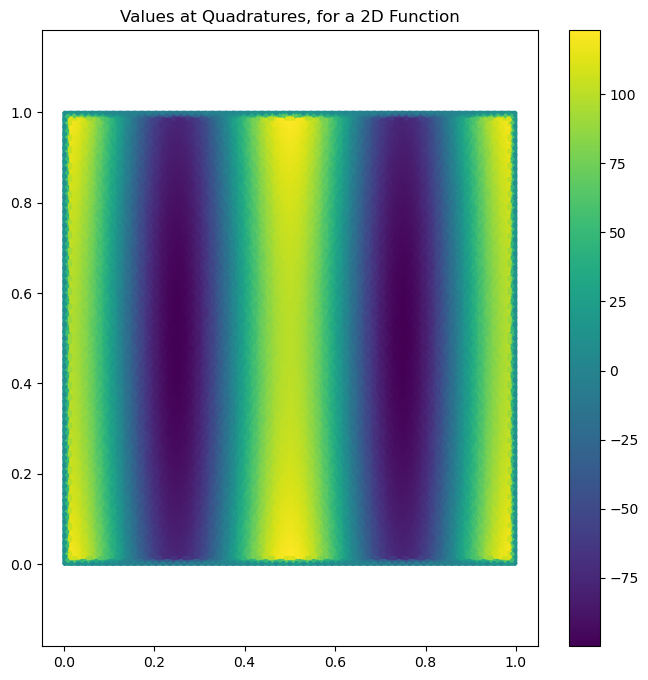

In [88]:
def v(x,y):
    return 100 * jnp.cos(4*jnp.pi*x) + 100 * (y-0.5)**2 

def lagrangian_density(u,grad_u,x):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y = x[0], x[1]
    f = v(x,y)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective(u_global):
    return femsystem.integrate(lagrangian_density,u_global)

# Now transform objective to enforce normalization and boundary conditions
real_objective = lambda u_interior: femsystem.apply_bc_and_norm(u_interior,objective)

femsystem.plot_values_2d(v)


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 9.309223175048828 Objective Value:66.83635711669922  Stepsize:0.4992544949054718  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 6.117135524749756 Objective Value:48.173255920410156  Stepsize:0.7488817572593689  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 5.545543193817139 Objective Value:26.094640731811523  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 10.006587028503418 Objective Value:19.42790985107422  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 4.758589744567871 Objective Value:9.694720268249512  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 3.5966084003448486 Objective Value:2.0841872692108154  Stepsiz

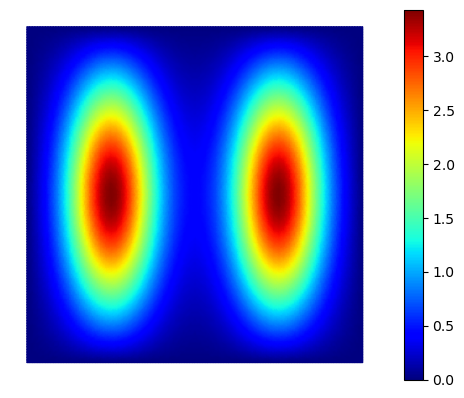

In [89]:
# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=real_objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points

femsystem.plot_at_interior_2d(result)

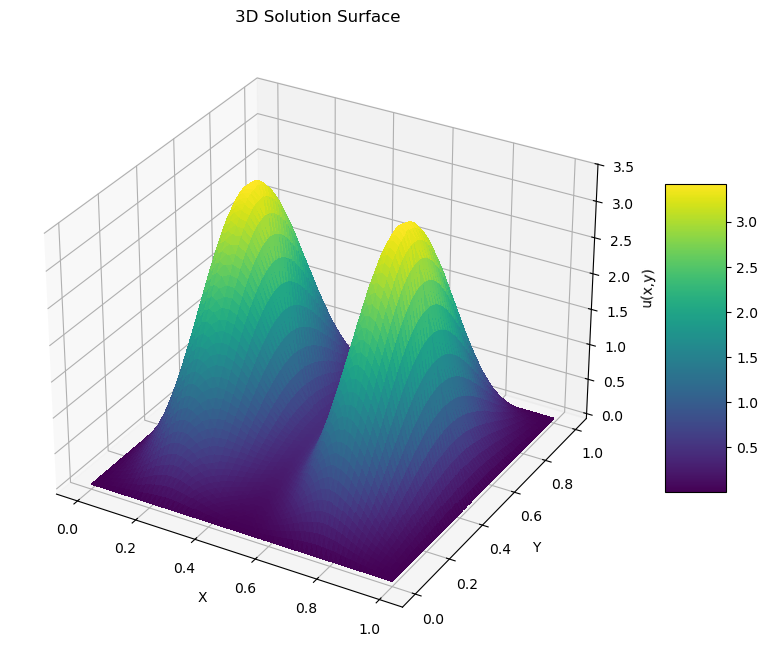

In [90]:
femsystem.plot_at_interior_2d_in3d(result)